# Florida Risk Analysis: Detailed Overview

This notebook provides a detailed walkthrough of the CLIMADA risk analysis workflow for Florida, covering Hazard, Exposure, Vulnerability, and Adaptation.

In [34]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

# Add src to path
sys.path.append(os.path.abspath("src"))

# CLIMADA Imports
from climada.hazard import TCTracks, TropCyclone, Centroids
from climada.entity import ImpactFuncSet, ImpfTropCyclone, Measure, MeasureSet, DiscRates, Entity, Exposures
from climada.engine import ImpactCalc, CostBenefit

# Custom Data Loaders
from exposure_loader import get_florida_exposure

%matplotlib inline
warnings.filterwarnings("ignore")
print("Environment ready.")

Environment ready.


## 1. Hazard: Storm Tracks

Storm tracks are created and stored in a separate class, `TCTracks`. We use its method `from_ibtracs_netcdf` to create the tracks from the IBTrACS storm tracks archive.

Loading full North Atlantic tracks...
Plotting 2017 tracks...


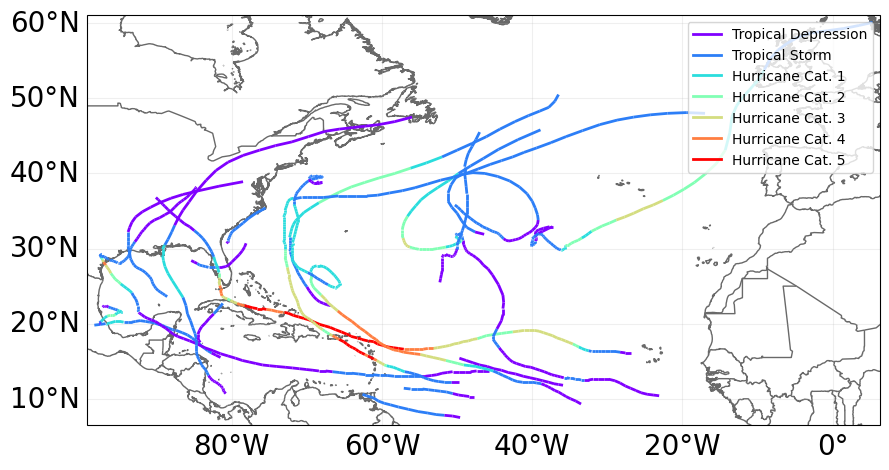

In [35]:
print("Loading full North Atlantic tracks...")
tracks = TCTracks.from_ibtracs_netcdf(provider="usa", basin="NA", year_range=(2000, 2020))

# Plotting tracks can be time consuming, so we choose only a few here (2017)
print("Plotting 2017 tracks...")
tracks_2017 = TCTracks.from_ibtracs_netcdf(
    provider="usa", basin="NA", year_range=(2017, 2017)
)
tracks_2017.plot();

It’s worth adding additional time steps to the tracks to smooth the footprint.

In [36]:
print("Interpolating time steps...")
tracks.equal_timestep(time_step_h=0.5)

Interpolating time steps...


### Centroids
We define a grid of centroids covering Florida.

Generating centroids...


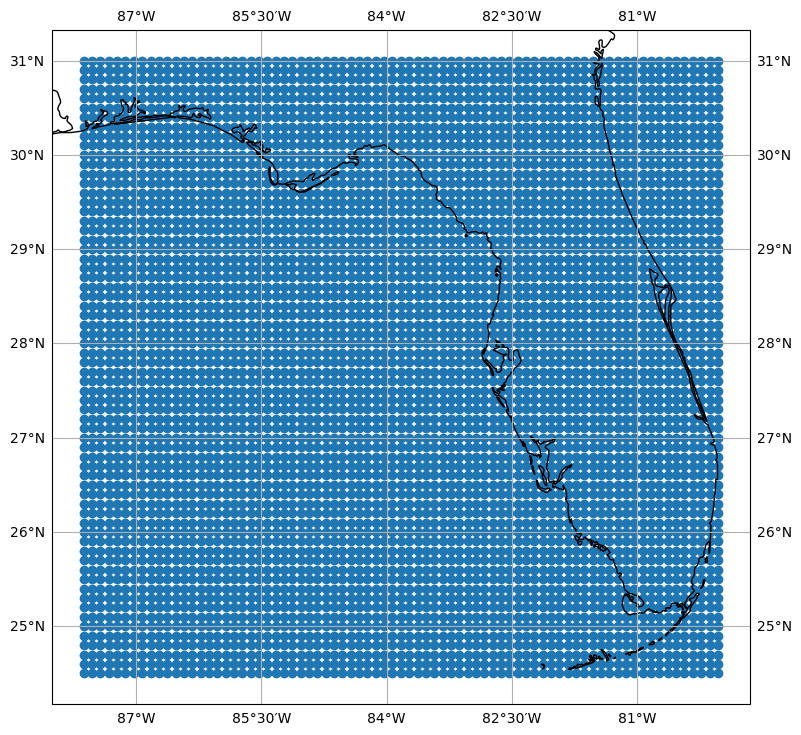

In [37]:
from climada.hazard import Centroids

# Florida Bounding Box
min_lon, min_lat, max_lon, max_lat = -87.63, 24.52, -80.03, 31.00

print("Generating centroids...")
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.1)
cent.plot();

### Hazard Footprint
We create the `TropCyclone` hazard object.

In [38]:
from climada.hazard import TropCyclone

print("Computing hazard wind fields...")
haz = TropCyclone.from_tracks(tracks, centroids=cent)
haz.check()  # verifies that the necessary data for the Hazard object is correctly provided

Computing hazard wind fields...


We can plot specific storm tracks. For Florida, **Hurricane Irma (2017)** is a key event (SID: `2017242N16333`).

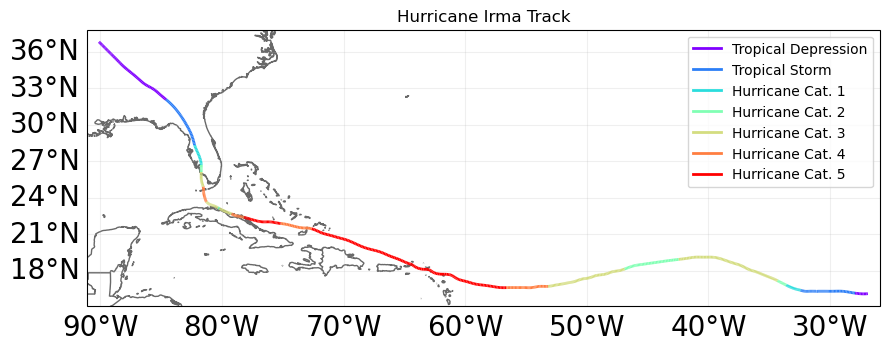

In [39]:
# Hurricane Irma 2017
irma_sid = "2017242N16333"
try:
    tracks.subset({"sid": irma_sid}).plot()
    plt.title("Hurricane Irma Track")
except:
    print("Irma track not found in subset, plotting first available.")
    tracks.subset({"sid": tracks.data[0].sid}).plot()

We can also plot hazard intensity return periods.

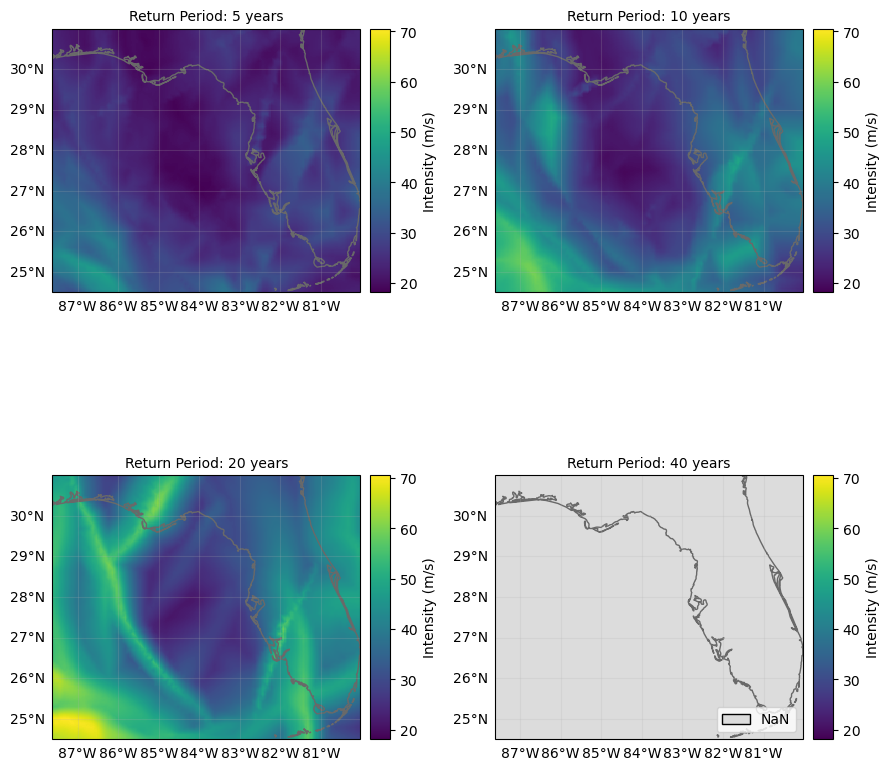

In [40]:
haz.plot_rp_intensity(return_periods=(5, 10, 20, 40));

## 2. Exposure
We load the economic exposure data generated from Nightlight intensities.

Loading exposure from data\exposure_fl_nightlight.hdf5


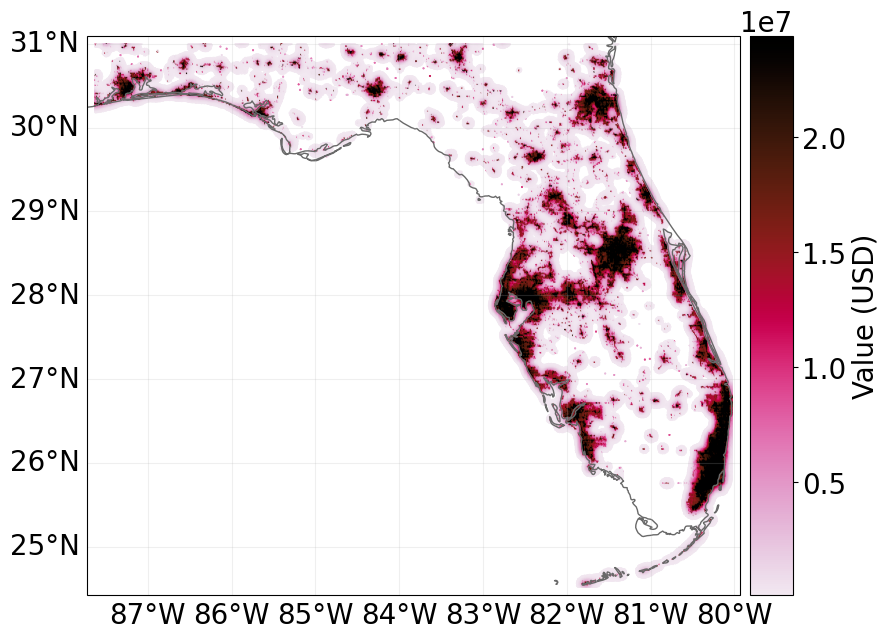

In [41]:
exp_litpop = get_florida_exposure(cache_dir="data")
exp_litpop.plot_hexbin(pop_name=False, buffer=0.1);

## 3. Impact Functions
We load and plot the standard Emanuel (2011) impact function.

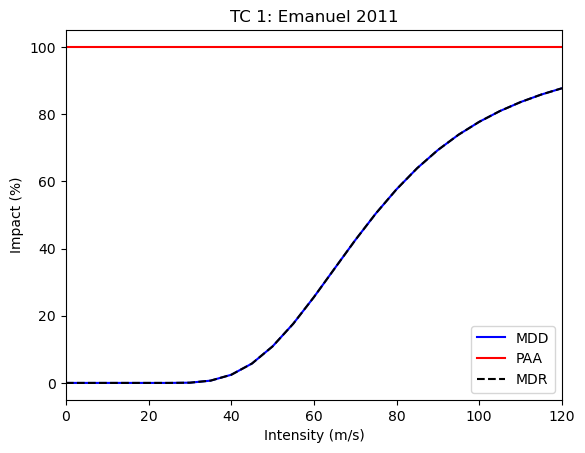

In [42]:
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

imp_fun = ImpfTropCyclone.from_emanuel_usa()
imp_fun.id = 1
imp_fun.haz_type = 'TC'
imp_fun.plot();

imp_fun_set = ImpactFuncSet([imp_fun])

# Map exposure to this function
if 'impf_TC' not in exp_litpop.gdf.columns:
    exp_litpop.gdf['impf_TC'] = 1

## 4. Adaptation Measures
We define adaptation measures like **Mangroves** and **Building Codes**.

In [43]:
from climada.entity import Measure, MeasureSet, ImpfTropCyclone
import copy
import numpy as np
import matplotlib.pyplot as plt

# --- PREPARATION: Create Impact Function ID 2 (Mangroves) ---
base_impf = imp_fun_set.get_func(haz_type='TC', fun_id=1)
impf_mangrove = copy.deepcopy(base_impf)
impf_mangrove.id = 2
impf_mangrove.name = 'TC Wind with Mangroves'
impf_mangrove.mdd = base_impf.mdd * 0.8 
imp_fun_set.append(impf_mangrove)

# --- MEASURE DEFINITION ---
meas_mangrove = Measure(
    name="Mangrove",
    haz_type="TC",
    color_rgb=np.array([0.2, 0.2, 0.7]),
    cost=500000000,
    mdd_impact=(1, 0),
    paa_impact=(1, -0.15),
    hazard_inten_imp=(1, -10),
    imp_fun_map="1to2"
)

meas_set = MeasureSet(measure_list=[meas_mangrove])
meas_set.check() 

print("Applying Mangroves measure...")
mangrove_exp, mangrove_imp_fun_set, mangrove_haz = meas_mangrove.apply(
    exp_litpop, imp_fun_set, haz
)



Applying Mangroves measure...


In [44]:
# --- PREPARATION: Create Impact Function ID 3 (Building Code) ---
impf_retrofit = copy.deepcopy(base_impf)
impf_retrofit.id = 3
impf_retrofit.name = 'TC Wind Retrofitted'
impf_retrofit.mdd = base_impf.mdd * 0.5
imp_fun_set.append(impf_retrofit)

# --- MEASURE DEFINITION ---
meas_buildings = Measure(
    name="Building code",
    haz_type="TC",
    color_rgb=np.array([0.2, 0.7, 0.5]),
    cost=100000000,
    hazard_freq_cutoff=0.1,
    imp_fun_map="1to3"
)

meas_set.append(meas_buildings)
meas_set.check()

print("Applying Building Code measure...")
buildings_exp, buildings_imp_fun_set, buildings_haz = meas_buildings.apply(
    exp_litpop, imp_fun_set, haz
) 

# Compare Hazard Return Periods
#haz.plot_rp_intensity(return_periods=(5, 20, 40, 100))

# TYPO FIX: changed .plot_rp to .plot_rp_intensity
#buildings_haz.plot_rp_intensity

Applying Building Code measure...


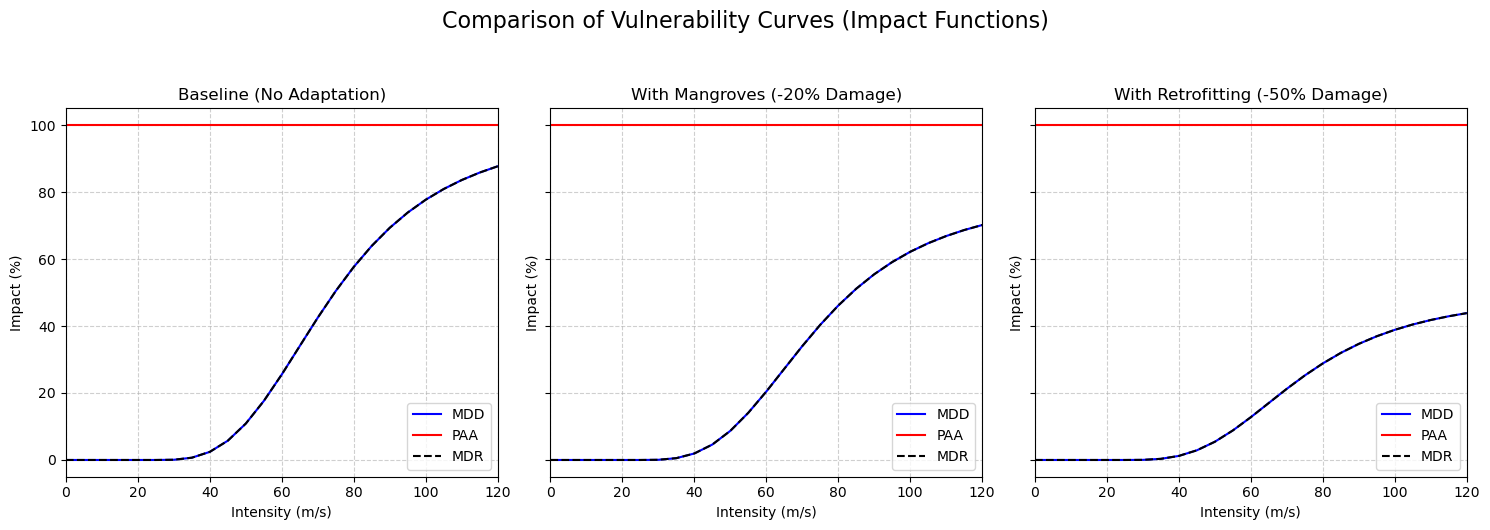

In [45]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot Base Function (ID 1)

imp_fun_set.get_func(haz_type='TC', fun_id=1).plot(axis=axes[0])
axes[0].set_title("Baseline (No Adaptation)")
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Mangrove Function (ID 2)
imp_fun_set.get_func(haz_type='TC', fun_id=2).plot(axis=axes[1])
axes[1].set_title("With Mangroves (-20% Damage)")
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot Retrofit Function (ID 3)
imp_fun_set.get_func(haz_type='TC', fun_id=3).plot(axis=axes[2])
axes[2].set_title("With Retrofitting (-50% Damage)")
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Comparison of Vulnerability Curves (Impact Functions)", fontsize=16, y=1.05)
plt.tight_layout
plt.tight_layout()
plt.show()

## 5. Discount Rates
We define discount rates for the Cost-Benefit Analysis.

<Axes: title={'center': 'Discount rates'}, xlabel='Year', ylabel='discount rate (%)'>

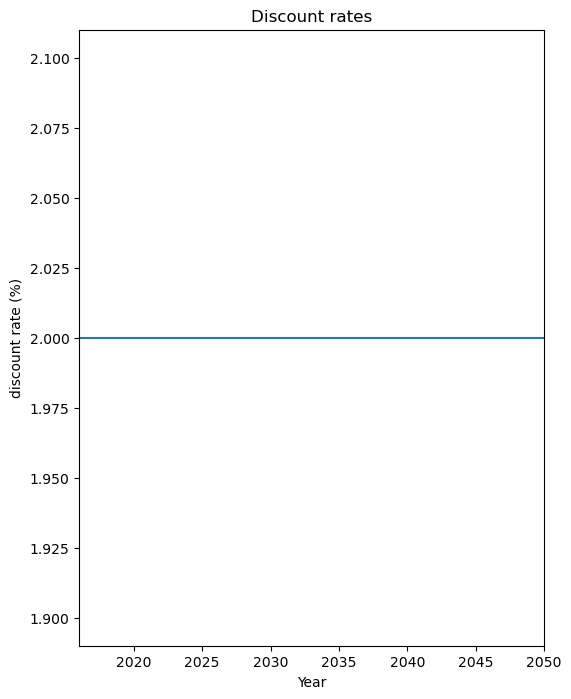

In [46]:
from climada.entity import DiscRates

# Years from 2016 to 2050
years = np.arange(2016, 2051)
rates = np.ones(years.size) * 0.02
disc = DiscRates(years=years, rates=rates)
disc.check()
disc.plot()

## 6. Entity & Impact
We bundle everything into an Entity and calculate the baseline impact.

Calculating baseline impact...


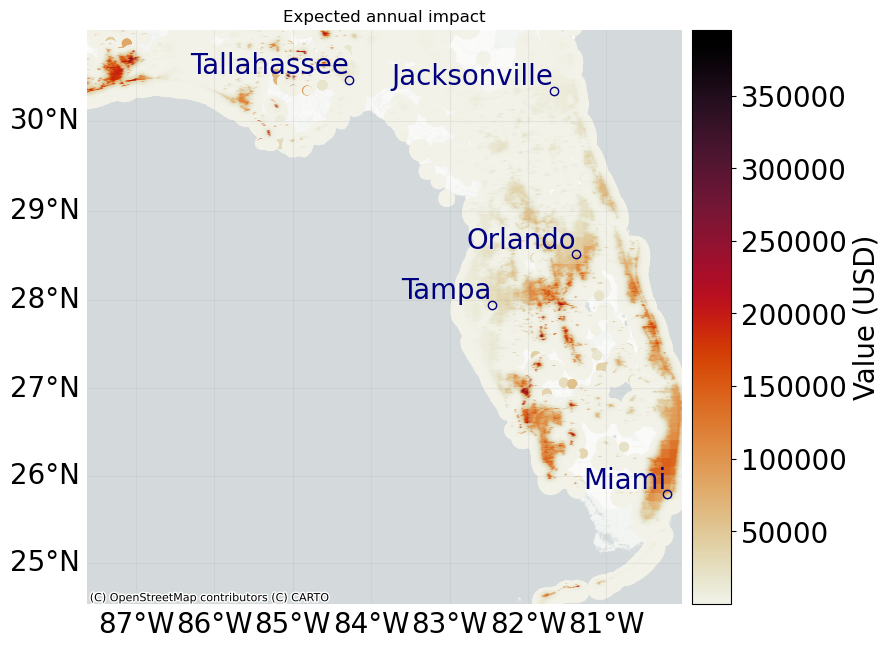

In [47]:
from climada.entity import Entity

ent = Entity(
    exposures=exp_litpop,
    disc_rates=disc,
    impact_func_set=imp_fun_set,
    measure_set=meas_set,
) 

# Calculate Impact
from climada.engine import ImpactCalc
print("Calculating baseline impact...")
imp = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact()

# Plot Expected Annual Impact Map
imp.plot_basemap_eai_exposure(buffer=0.1);  # average annual impact at each exposure

## 7. Cost-Benefit Analysis
We calculate the Net Present Value (NPV) and Benefit-Cost Ratio (BCR) for the measures.

Calculating Cost-Benefit...

Measure          Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-------------  ---------------  ------------------  --------------
Mangrove                   0.5             191.09          382.181
Building code              0.1             160.822        1608.22

--------------------  ---------  --------
Total climate risk:    210.512   (USD bn)
Average annual risk:    10.5711  (USD bn)
Residual risk:        -141.4     (USD bn)
--------------------  ---------  --------
Net Present Values


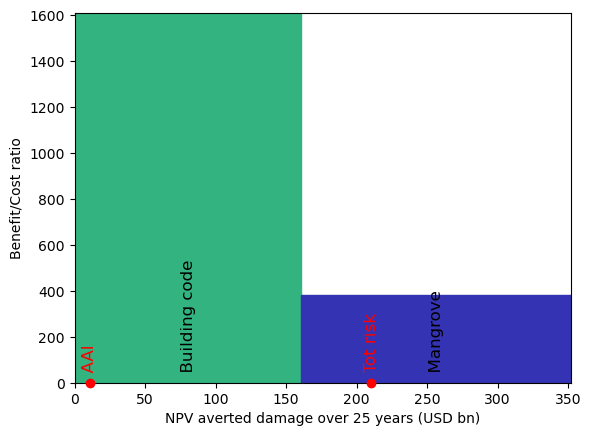

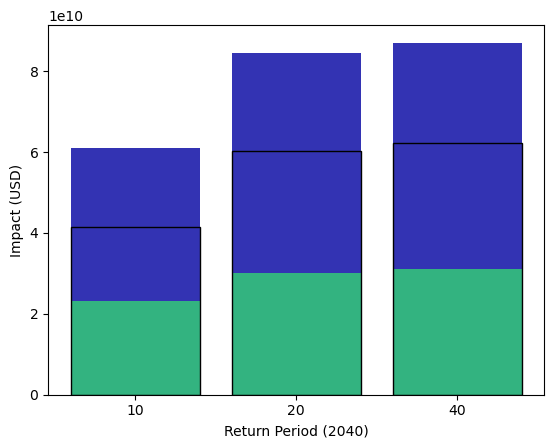

In [48]:
from climada.engine import CostBenefit

print("Calculating Cost-Benefit...")
cost_ben = CostBenefit()
cost_ben.calc(haz, ent, future_year=2040)  # prints costs and benefits

cost_ben.plot_cost_benefit()

# plot cost benefit ratio and averted damage of every exposure
cost_ben.plot_event_view(
    return_per=(10, 20, 40)
);  # plot averted damage of each measure for every return period

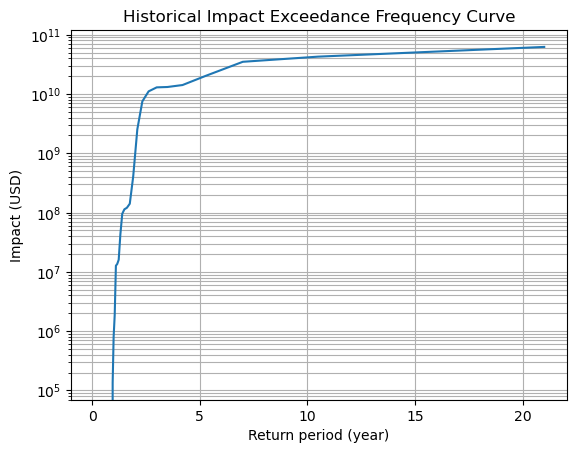

In [49]:
# Calculate and Plot Exceedance Frequency Curve (EP Curve)
# X-axis: Return Period (Years), Y-axis: Exceedance Impact (USD)
freq_curve = imp.calc_freq_curve()
freq_curve.plot()
plt.title("Historical Impact Exceedance Frequency Curve")
plt.yscale('log') # Easier to see large range of values
plt.grid(True, which="both")

Loaded 6534 historical tracks (1980-2020).
10-Year Impact: 17,179,565,003 USD
50-Year Impact: 48,874,684,855 USD
100-Year Impact: 60,812,343,237 USD


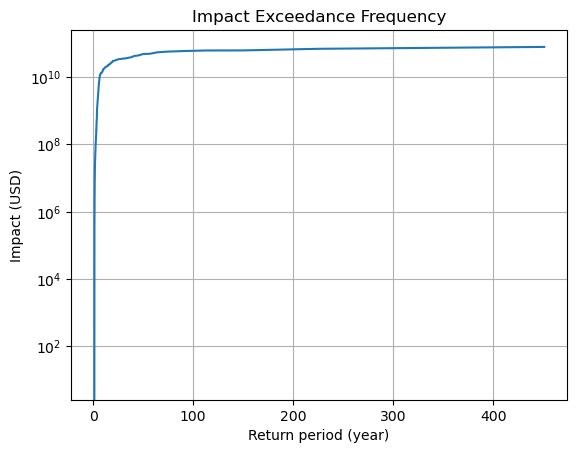

In [50]:
# ALTERNATIVE: Statistical Extrapolation (Extreme Value Theory)

from climada.engine import ImpactFreqCurve
import matplotlib.pyplot as plt
# Filter manually if needed, or just use the last 40 years
# Using a longer history (1980-2020) is better for synthetic generation statistics
tracks_full = tracks_full.subset_year(start_date=(1980, 1, 1), end_date=(2020, 12, 31))
tracks_full.equal_timestep(time_step_h=0.5)
print(f"Loaded {tracks_full.size} historical tracks (1980-2020).")

# Ensure we have tracks loaded (reload if necessary to be safe)
if 'tracks_full' not in locals():
    tracks_full = TCTracks.from_ibtracs_netcdf(provider="usa", basin="NA", year_range=(1980, 2020))

# 1. Calculate Historical Impact
haz_hist_full = TropCyclone.from_tracks(tracks_full, centroids=cent)
imp_hist_full = ImpactCalc(exp_litpop, imp_fun_set, haz_hist_full).impact()

# 2. Calc Frequency Curve
ifc = imp_hist_full.calc_freq_curve()

# 3. Plot
ax = ifc.plot(label='Historical Data')
plt.title("Impact Exceedance Frequency")
plt.yscale('log')
plt.grid(True, which="both")

# 4. Get Return Period Values (Universal Method)
# We interpolate directly from the curve data points
def get_impact_at_rp(ifc, rp):
    # return_per is increasing, impact is increasing
    return np.interp(rp, ifc.return_per, ifc.impact)

print(f"10-Year Impact: {get_impact_at_rp(ifc, 10):,.0f} USD")
print(f"50-Year Impact: {get_impact_at_rp(ifc, 50):,.0f} USD")
print(f"100-Year Impact: {get_impact_at_rp(ifc, 100):,.0f} USD")

Plotting Hazard Intensity Maps for Return Periods...


(array([<GeoAxes: title={'center': 'Return Period: 10 years'}>,
        <GeoAxes: title={'center': 'Return Period: 20 years'}>,
        <GeoAxes: title={'center': 'Return Period: 40 years'}>],
       dtype=object),
 array([[25.99665115, 24.66167618, 24.36076438, ..., 25.59422321,
         25.29349611, 24.9540664 ],
        [31.89673523, 31.97981342, 32.15754303, ..., 36.15800963,
         36.15162809, 35.0568208 ],
        [38.08805624, 38.48857671, 39.19873175, ..., 42.17719005,
         43.20265566, 44.33365927]], shape=(3, 5082)))

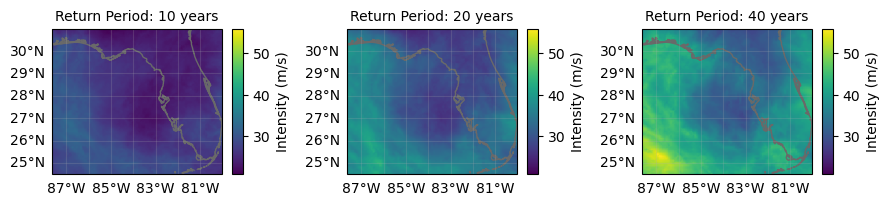

In [51]:
# Plot Historical Return Period Intensity Maps (up to max dataset length)
# Since we have ~40 years of data, we can visualize up to ~40 year RP
print("Plotting Hazard Intensity Maps for Return Periods...")

# This will look at the history at each pixel and find the N-th highest wind speed
# RP 10 = ~4th highest event in 40 years
# RP 40 = Highest event in 40 years
haz_hist_full.plot_rp_intensity(return_periods=(10, 20, 40))

In [52]:
from climada.util.coordinates import dist_approx
import numpy as np

# 1. Select a specific location (Miami)
lat_miami, lon_miami = 25.7617, -80.1918

# 2. Calculate distances using CLIMADA's dist_approx
# Inputs need to be arrays
lat_centroids = haz_hist_full.centroids.lat
lon_centroids = haz_hist_full.centroids.lon

# We need to reshape inputs to match dist_approx expectation (nbatch, n_points)
# or simply broadcast. But dist_approx handles arrays.
# Let's use the simple manual broadcasting which is robust:
lats1 = np.array([lat_miami])
lons1 = np.array([lon_miami])

# dist_approx expects shape (nbatch, nx) and (nbatch, ny)
# We treat this as batch=1
dists = dist_approx(
    lats1[None, :], lons1[None, :], 
    lat_centroids[None, :], lon_centroids[None, :], 
    method="geosphere", units="km"
)

# Result is (nbatch, nx, ny) -> (1, 1, n_centroids)
dists_flat = dists[0, 0, :]
cent_idx = np.argmin(dists_flat)

print(f"Nearest centroid index: {cent_idx} (Distance: {dists_flat[cent_idx]:.2f} km)")

Nearest centroid index: 4078 (Distance: 5.72 km)


Miami 100-Year Wind Estimation (LP3): 106.1 m/s


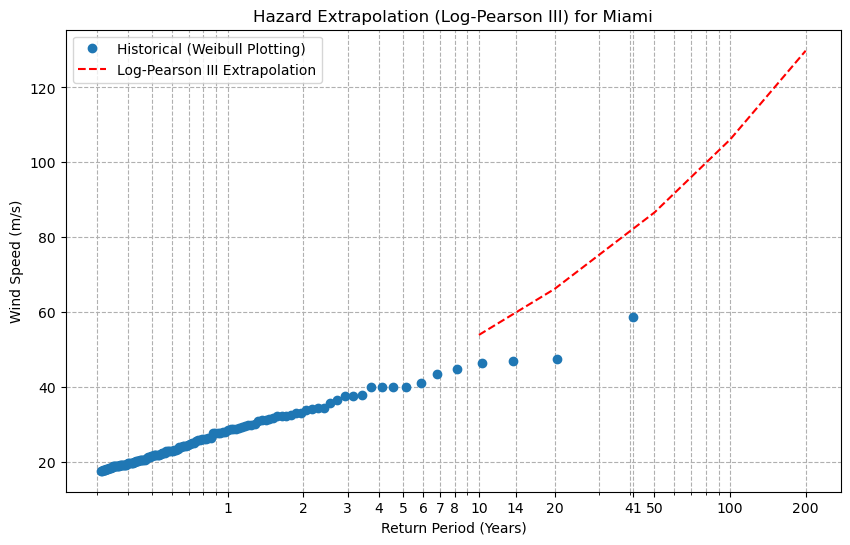

In [53]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from climada.util.coordinates import dist_approx

# 1. Select a specific location (Miami)
lat_miami, lon_miami = 25.7617, -80.1918

# Calculate distance to find nearest centroid (Robust method)
lats1 = np.array([lat_miami])
lons1 = np.array([lon_miami])
lat_centroids = haz_hist_full.centroids.lat
lon_centroids = haz_hist_full.centroids.lon

dists = dist_approx(
    lats1[None, :], lons1[None, :], 
    lat_centroids[None, :], lon_centroids[None, :], 
    method="geosphere", units="km"
)
cent_idx = np.argmin(dists[0, 0, :])

# 2. Extract Historical Wind Speeds (40 Years)
winds_miami = haz_hist_full.intensity[:, cent_idx].toarray().flatten()
events_miami = winds_miami[winds_miami > 15] # Filter for meaningful storms

if len(events_miami) > 5:
    # --- LOG-PEARSON TYPE III IMPLEMENTATION ---
    
    # A. Log-Transform the data
    log_winds = np.log10(events_miami)
    
    # B. Fit Pearson Type III to the log-values
    # skew, loc (mean), scale (std dev)
    skew, loc, scale = stats.pearson3.fit(log_winds)
    
    # C. Define Return Periods to extrapolate
    rp_years = np.array([10, 20, 50, 100, 200])
    
    # D. Calculate Magnitude for these Return Periods
    # Probability of non-exceedance: P = 1 - (1 / (RP * Rate))
    # We adjust for the fact that we have >1 storm per year on average or <1
    rate_per_year = len(events_miami) / 40.0
    exceedance_prob = 1 / (rp_years * rate_per_year)
    non_exceedance_prob = 1 - exceedance_prob
    
    # Use Inverse CDF (ppf) to get log values, then exponentiate back
    log_prediction = stats.pearson3.ppf(non_exceedance_prob, skew, loc=loc, scale=scale)
    lp3_winds = 10**log_prediction
    
    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    
    # Plot Historical Points (using Weibull plotting position N+1 for better visual fit)
    sorted_winds = np.sort(events_miami)[::-1]
    hist_rps = (40.0 + 1) / np.arange(1, len(sorted_winds)+1)
    plt.semilogx(hist_rps, sorted_winds, 'o', label='Historical (Weibull Plotting)')
    
    # Plot Log-Pearson III Curve
    plt.semilogx(rp_years, lp3_winds, 'r--', label='Log-Pearson III Extrapolation')
    
    plt.xlabel("Return Period (Years)")
    plt.ylabel("Wind Speed (m/s)")
    plt.title(f"Hazard Extrapolation (Log-Pearson III) for Miami")
    plt.grid(True, which="both", linestyle="--")
    plt.legend()
    
    # Custom x-ticks without scientific notation (10^ format)
    xticks = np.concatenate((hist_rps, rp_years))
    xticks = np.unique(np.round(xticks)) # Ensure uniqueness and round for clarity
    xticks = xticks[xticks >= 1]  # Avoid ticks at zero or negative

    plt.xticks(xticks, [f"{int(x)}" for x in xticks])
    
    print(f"Miami 100-Year Wind Estimation (LP3): {lp3_winds[3]:.1f} m/s")
    plt.show()

else:
    print("Not enough storm data in Miami to fit a curve.")